In [1]:
import numpy as np
import pandas as pd
import os
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder,StandardScaler
import os

2025-02-26 10:01:38.100079: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Importing the different files into the environment
X_test = pd.read_csv("data_folder/X_test.csv")
X_train = pd.read_csv("data_folder/X_train.csv")
y_train = pd.read_csv("data_folder/y_train.csv")


In [3]:
num_classes = 24

In [4]:
Y = to_categorical(y_train['eqt_code_cat'], num_classes=num_classes)

In [5]:
categorical_columns = ['venue', 'action', 'side']
numeric_columns = ['price', 'bid', 'ask', 'bid_size', 'ask_size', 'flux']

# Encoding
for col in categorical_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])


In [ ]:
import numpy as np
import pandas as pd

def add_feature_engineering(df):
    # Bid-ask ratio and imbalance
    df['bid_ask_ratio'] = df['bid_size'] / (df['ask_size'] + 1e-6)
    df['imbalance'] = df['bid_size'] - df['ask_size']
    df['normalized_imbalance'] = df['imbalance'] / (df['bid_size'] + df['ask_size'] + 1e-6)

    # Price and spread features
    df['price_change'] = df.groupby('obs_id')['price'].diff()
    df['cumulative_price_change'] = df.groupby('obs_id')['price_change'].cumsum()
    df['bid_ask_spread'] = df['ask'] - df['bid']
    df['relative_spread'] = df['bid_ask_spread'] / (df['price'] + 1e-6)
    df['mid_price'] = (df['bid'] + df['ask']) / 2
    df['mid_price_change'] = df.groupby('obs_id')['mid_price'].diff()

    # Price ratios
    df['price_bid_ratio'] = df['price'] / (df['bid'] + 1e-6)
    df['price_ask_ratio'] = df['price'] / (df['ask'] + 1e-6)

    df['log_bid_size'] = np.log(df['bid_size'] + 1)
    df['log_ask_size'] = np.log(df['ask_size'] + 1)
    df['log_flux'] = np.log(np.abs(df['flux']) + 1) * np.sign(df['flux'])
    df['log_flux_change'] = df.groupby('obs_id')['log_flux'].diff()

    # Volatility (standard deviation within sequences)
    df['rolling_volatility'] = df.groupby('obs_id')['price'].transform(lambda x: x.rolling(window=5, min_periods=1).std())

    # Momentum indicators
    df['momentum_3'] = df.groupby('obs_id')['price'].diff(periods=3)
    df['momentum_5'] = df.groupby('obs_id')['price'].diff(periods=5)
    df['momentum_10'] = df.groupby('obs_id')['price'].diff(periods=10)

    # Order flow imbalance (OFI)
    df['ofi'] = (df['bid_size'] - df.groupby('obs_id')['bid_size'].shift(1)) - (df['ask_size'] - df.groupby('obs_id')['ask_size'].shift(1))

    # Price direction indicators
    df['price_up'] = (df['price_change'] > 0).astype(int)
    df['price_down'] = (df['price_change'] < 0).astype(int)

    # Trade impact
    df['trade_impact'] = df['trade'] * df['flux']

    # **Nouveaux indicateurs avancés**
    
    # **1. Indicateurs d'agressivité des ordres**
    df['aggressiveness'] = (df['flux'] / (df['bid_size'] + df['ask_size'] + 1e-6))
    
    # **2. Indicateurs de liquidité**
    df['liquidity_depth'] = df['bid_size'] + df['ask_size']
    df['log_liquidity_depth'] = np.log(df['liquidity_depth'] + 1)

    # **3. Mesures de dispersion du marché**
    df['price_volatility_10'] = df.groupby('obs_id')['price'].rolling(10).std().reset_index(level=0, drop=True)
    df['spread_volatility_10'] = df.groupby('obs_id')['bid_ask_spread'].rolling(10).std().reset_index(level=0, drop=True)

    # **4. Signaux de tendance court-terme**
    df['trend_5'] = df.groupby('obs_id')['mid_price'].diff(periods=5)
    df['trend_10'] = df.groupby('obs_id')['mid_price'].diff(periods=10)

    # **5. Indicateurs de pression acheteurs/vendeurs**
    df['buy_pressure'] = df['bid_size'] / (df['bid_size'] + df['ask_size'] + 1e-6)
    df['sell_pressure'] = df['ask_size'] / (df['bid_size'] + df['ask_size'] + 1e-6)

    # **6. Indicateurs liés au carnet d’ordre**
    df['order_imbalance'] = (df['bid_size'] - df['ask_size']) / (df['bid_size'] + df['ask_size'] + 1e-6)
    df['market_depth_ratio'] = (df['bid_size'] + df['ask_size']) / (df['bid_ask_spread'] + 1e-6)

    # **7. Indicateurs de volume**
    df['volume_change'] = df.groupby('obs_id')['bid_size'].diff() + df.groupby('obs_id')['ask_size'].diff()
    df['log_volume_change'] = np.log(np.abs(df['volume_change']) + 1) * np.sign(df['volume_change'])

    # **8. Mesures de volatilité du flux**
    df['flux_volatility'] = df.groupby('obs_id')['flux'].rolling(5).std().reset_index(level=0, drop=True)
    df['flux_skewness'] = df.groupby('obs_id')['flux'].apply(lambda x: x.skew() if len(x) > 1 else 0)

    # **9. Indicateurs de directionnalité du carnet**
    df['bid_strength'] = df['bid_size'] / (df['bid_size'].rolling(5).sum() + 1e-6)
    df['ask_strength'] = df['ask_size'] / (df['ask_size'].rolling(5).sum() + 1e-6)

    # **10. Features combinées**
    df['market_pressure'] = df['bid_size'] / (df['bid_size'] + df['ask_size'] + df['bid_ask_spread'] + 1e-6)
    df['volatility_adjusted_spread'] = df['bid_ask_spread'] / (df['rolling_volatility'] + 1e-6)

    df.fillna(0, inplace=True)
    return df


X_train = add_feature_engineering(X_train)
X_test = add_feature_engineering(X_test)

/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
import numpy as np
import pandas as pd

def summarize_by_obs(df):
    # Statistiques sur les variables numériques
    summary = df.groupby('obs_id').agg({
        'bid_ask_ratio': ['mean', 'std', 'min', 'max'],
        'imbalance': ['mean', 'std', 'min', 'max'],
        'normalized_imbalance': ['mean', 'std'],
        'price_change': ['mean', 'std', 'min', 'max'],
        'cumulative_price_change': ['mean', 'std'],
        'bid_ask_spread': ['mean', 'std', 'min', 'max'],
        'relative_spread': ['mean', 'std'],
        'mid_price_change': ['mean', 'std'],
        'price_bid_ratio': ['mean', 'std'],
        'price_ask_ratio': ['mean', 'std'],
        'log_bid_size': ['mean', 'std', 'min', 'max'],
        'log_ask_size': ['mean', 'std', 'min', 'max'],
        'log_flux': ['mean', 'std', 'min', 'max'],
        'log_flux_change': ['mean', 'std'],
        'rolling_volatility': ['mean', 'max'],
        'momentum_3': ['mean', 'std'],
        'momentum_5': ['mean', 'std'],
        'momentum_10': ['mean', 'std'],
        'ofi': ['mean', 'std'],
        'trade_impact': ['mean', 'std'],
        'aggressiveness': ['mean', 'std'],
        'liquidity_depth': ['mean', 'std', 'min', 'max'],
        'log_liquidity_depth': ['mean', 'std'],
        'price_volatility_10': ['mean', 'std'],
        'spread_volatility_10': ['mean', 'std'],
        'trend_5': ['mean', 'std'],
        'trend_10': ['mean', 'std'],
        'buy_pressure': ['mean', 'std'],
        'sell_pressure': ['mean', 'std'],
        'order_imbalance': ['mean', 'std'],
        'market_depth_ratio': ['mean', 'std'],
        'volume_change': ['mean', 'std'],
        'log_volume_change': ['mean', 'std'],
        'flux_volatility': ['mean', 'std'],
        'flux_skewness': ['mean'],  # Skewness (asymétrie de la distribution)
        'bid_strength': ['mean', 'std'],
        'ask_strength': ['mean', 'std'],
        'market_pressure': ['mean', 'std'],
        'volatility_adjusted_spread': ['mean', 'std']
    })

    # Aplatir les noms de colonnes
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]

    # **Ajout de skewness et kurtosis**
    for col in ['price', 'flux', 'bid_ask_spread']:
        summary[f"{col}_skew"] = df.groupby('obs_id')[col].skew()
        summary[f"{col}_kurtosis"] = df.groupby('obs_id')[col].apply(lambda x: x.kurtosis() if len(x) > 1 else 0)

    # **Fréquences des variables catégoriques**
    for col in ['venue', 'action', 'side', 'trade']:
        freq = df.groupby('obs_id')[col].value_counts(normalize=True).unstack(fill_value=0)
        freq.columns = [f"{col}_{val}" for val in freq.columns]  # Suffixe pour éviter les conflits
        summary = summary.join(freq, how='left')

    # Remplir les valeurs manquantes
    summary.fillna(0, inplace=True)
    
    return summary


In [10]:
X_train = summarize_by_obs(X_train)
X_test = summarize_by_obs(X_test)

In [12]:
X_train_summarize = X_train.reset_index(drop=True)
X_test_summarize = X_test.reset_index(drop=True)

# Standardization of the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_summarize)
X_test_scaled = scaler.transform(X_test_summarize)

# Re-conversion to DataFrame with original column names
X_train_ = pd.DataFrame(X_train_scaled, columns=X_train_summarize.columns, index=X_train_summarize.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_summarize.columns, index=X_test_summarize.index)

In [13]:
X_train_

,bid_ask_ratio_mean,bid_ask_ratio_std,bid_ask_ratio_min,bid_ask_ratio_max,Imbalance_mean,Imbalance_std,price_change_mean,price_change_std,cumulative_price_change_mean,cumulative_price_change_std,...,venue_3,venue_4,venue_5,action_0,action_1,action_2,side_0,side_1,trade_0,trade_1
0,1.368031,1.616339,-0.050740,1.081090,0.052462,-0.330099,0.044248,-0.332718,-0.115731,-0.346660,...,-0.928345,1.470648,-1.417140,0.365636,-0.145692,-0.538666,-0.117251,0.117251,0.419289,-0.419289
1,-0.272040,-0.332341,-0.069682,-0.351555,0.095088,-0.355634,0.031405,-0.333850,0.025981,-0.341957,...,-0.503416,0.901981,-0.168235,-0.150389,-1.724386,4.452420,-1.101987,1.101987,-2.253635,2.253635
2,-0.219879,-0.304969,-0.053385,-0.345560,2.018094,3.776900,-0.003912,-0.399829,0.001342,-0.401229,...,2.046156,0.404396,-0.346650,1.139674,-0.935039,-0.538666,0.375116,-0.375116,-0.471686,0.471686
3,-0.128352,-0.121320,-0.069715,-0.235650,0.298559,0.084003,-0.228655,-0.307782,-0.013875,-0.318502,...,-1.069988,0.333313,-1.238725,0.107623,-0.145692,0.085220,2.098404,-2.098404,0.419289,-0.419289
4,-0.283544,-0.340753,-0.068597,-0.363385,-1.354193,1.095648,-0.000701,-0.394931,0.004781,-0.398661,...,0.204798,0.262229,-0.435858,-0.408402,0.643655,-0.538666,0.190478,-0.190478,0.419289,-0.419289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153815,0.046474,0.325932,-0.069061,0.137542,-0.274141,-0.337640,0.008931,-0.233960,-0.098630,-0.264187,...,-0.645059,1.399565,-1.238725,-0.150389,0.117424,0.085220,0.128932,-0.128932,0.419289,-0.419289
153816,-0.291302,-0.357987,-0.069313,-0.385268,-1.273667,-0.358798,-0.048860,-0.135681,-0.033851,-0.171309,...,-0.786702,0.048979,0.367010,0.623649,-0.671923,0.085220,-0.486527,0.486527,0.419289,-0.419289
153817,-0.256045,-0.295907,-0.069534,-0.296847,-0.180043,-0.593711,0.018563,-0.318785,-0.003558,-0.350314,...,-0.361773,-0.235355,0.367010,-0.150389,0.380539,-0.538666,-0.178797,0.178797,-1.362661,1.362661
153818,-0.262137,-0.318347,-0.067760,-0.334233,-0.091691,-0.478103,0.005720,-0.355685,0.016747,-0.357180,...,-0.503416,0.617647,-0.168235,-1.440453,1.433002,0.085220,-0.117251,0.117251,-1.362661,1.362661


In [15]:
df = pd.DataFrame(Y)

# Group every 100 rows (for example, by taking the first of each group)
group_size = 100
grouped = df.groupby(df.index // group_size).first()

# Convert the result to an array if needed
Y = grouped.to_numpy()


In [16]:
indices = np.argmax(Y, axis=1)
indices

array([10, 15,  0, ...,  3, 11,  5])

In [17]:
from sklearn import model_selection
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train_, indices, train_size=0.8, random_state=42)


In [18]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Initialization and training of the XGBClassifier model
params_1 = {
    'booster': 'gbtree',
    'tree_method':'hist',
    'max_depth': 12, 
    'learning_rate': 0.01,
    'objective': 'multi:softprob',
    'num_class': num_classes,
    'eval_metric':'mlogloss'
    }

# Creating DMatrix for training and validation sets, replacing 0 values with NaN
d_train = xgb.DMatrix(X_train.replace({0:np.nan}), y_train)
d_valid = xgb.DMatrix(X_valid.replace({0:np.nan}), y_valid)

# Number of boosting rounds
num_round = 100

# Evaluation list for training and validation sets
evallist = [(d_train, 'train'), (d_valid, 'eval')]

# Training the model with early stopping
bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)


/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mlogloss:3.14809	eval-mlogloss:3.15785
[1]	train-mlogloss:3.11945	eval-mlogloss:3.13865
[2]	train-mlogloss:3.09179	eval-mlogloss:3.12017
[3]	train-mlogloss:3.06503	eval-mlogloss:3.10236
[4]	train-mlogloss:3.03907	eval-mlogloss:3.08525
[5]	train-mlogloss:3.01390	eval-mlogloss:3.06868
[6]	train-mlogloss:2.98940	eval-mlogloss:3.05261
[7]	train-mlogloss:2.96551	eval-mlogloss:3.03713
[8]	train-mlogloss:2.94226	eval-mlogloss:3.02205
[9]	train-mlogloss:2.91952	eval-mlogloss:3.00732
[10]	train-mlogloss:2.89741	eval-mlogloss:2.99310
[11]	train-mlogloss:2.87580	eval-mlogloss:2.97915
[12]	train-mlogloss:2.85466	eval-mlogloss:2.96559
[13]	train-mlogloss:2.83405	eval-mlogloss:2.95251
[14]	train-mlogloss:2.81390	eval-mlogloss:2.93977
[15]	train-mlogloss:2.79418	eval-mlogloss:2.92724
[16]	train-mlogloss:2.77480	eval-mlogloss:2.91501
[17]	train-mlogloss:2.75566	eval-mlogloss:2.90300
[18]	train-mlogloss:2.73694	eval-mlogloss:2.89114
[19]	train-mlogloss:2.71849	eval-mlogloss:2.87961
[20]	train

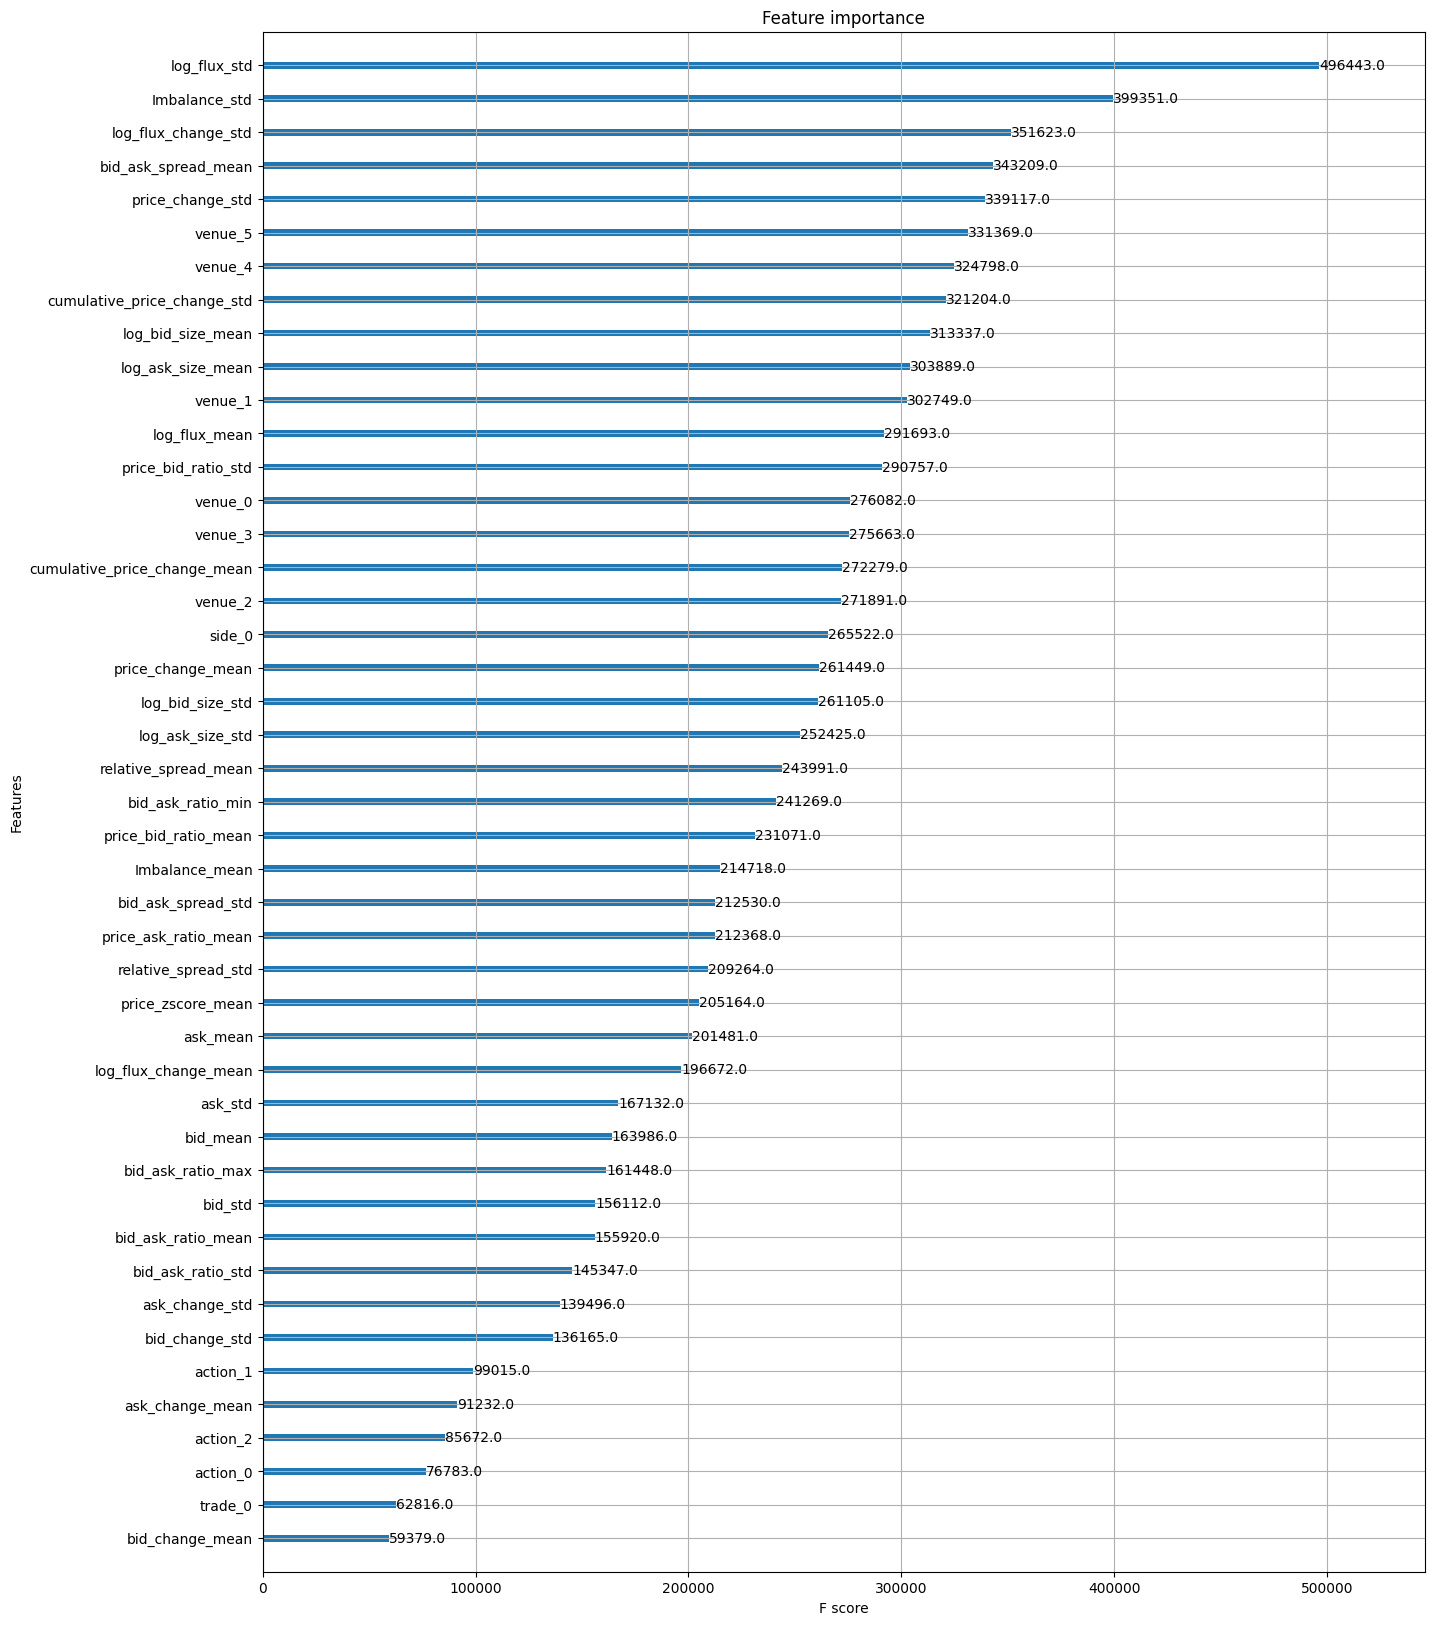

In [19]:
import matplotlib.pyplot as plt 

xgb.plot_importance(bst, max_num_features=60)
fig = plt.gcf()
fig.set_size_inches(15, 20)

In [21]:
X_bench = xgb.DMatrix(X_test)
predictions = bst.predict(X_bench, iteration_range=(0, bst.best_iteration))


In [22]:
indices_result = np.argmax(predictions, axis=1)

In [23]:
predictions = pd.DataFrame({'eqt_code_cat':indices_result})

In [25]:
predictions.to_csv('predict.csv') 
# score : 0.257, that's not a good score but it's relevant compare to a constant that would give us only 1/24 accuracy